In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import metrics
from sklearn.model_selection import train_test_split
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

#  CNN classifier ('Close(t + day_step) > Close(t)')

In [ ]:
from torch.nn import Linear, ReLU, Conv2d, MaxPool2d, Dropout

class CNNStockNetwork(nn.Module):

    def __init__(self, num_features, num_filters, drop, **kwargs):
        super(CNNStockNetwork, self).__init__()

        self.conv1 = Conv2d(1, num_filters, kernel_size=(1, num_features))
        self.relu1 = ReLU()
        self.conv2 = Conv2d(num_filters, num_filters, kernel_size=(3, 1))
        self.relu2 = ReLU()
        self.pool1 = MaxPool2d(kernel_size=(2, 1))
        self.conv3 = Conv2d(num_filters, num_filters, kernel_size=(3, 1))
        self.relu3 = ReLU()
        self.pool2 = MaxPool2d(kernel_size=(2, 1))
        self.drop1 = Dropout(drop)
        self.fc1 = Linear(104, 1)
        self.loss = torch.nn.BCEWithLogitsLoss()
 
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.pool1(x)
        x = self.relu3(self.conv3(x))
        x = self.pool2(x)
        x = self.drop1(x.view(x.shape[0], -1))
        x = self.fc1(x).squeeze(-1)
        return x

class CNNStock:         

    def __init__(self, **kwargs):

        default_kwargs = {
            'epochs': 7,
            'batch_size': 128,
            'validate': True,
            "save_best_dev": False,
            "use_cuda": True,
            "print_every_step": 1000,
            "eval_metrics": 'f1',
            'seq_len': 60
        }

        default_kwargs.update(kwargs)
        self.kwargs = default_kwargs

        self.network = CNNStockNetwork(**kwargs)

        self.n_epochs = kwargs["epochs"]
        self.batch_size = kwargs["batch_size"]
        self.use_cuda = kwargs["use_cuda"]
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-4)
        self.print_every_step = kwargs["print_every_step"]
        self.print_every_epoch = kwargs["print_every_epoch"]

        self.validate = kwargs["validate"]
        self.save_best_dev = kwargs["save_best_dev"]
        self.eval_metrics = kwargs["eval_metrics"]
        self._best_accuracy = 0.0
        self.best_val_results = 0

        self.val_data = kwargs['data_val']
        self.train_data = kwargs['data_train']
        self.seq_len = kwargs['seq_len']

        self.device = 'cpu'
        if torch.cuda.is_available() and self.use_cuda:
            self.device = 'cuda:0'
        self.train_loss = []
        self.train_accuracy = []
        self.val_loss = []
        self.val_accuracy = []

    def window_data(self, data, target, seq_len=60):
        windowed_data = []
        windowed_target = []
        for index in range(data.shape[0] - seq_len + 1):
            windowed_data.append(data[index:index + seq_len])
            windowed_target.append(target[index + seq_len - 1])
        return np.array(windowed_data), np.array(windowed_target)

    def get_batches(self, data, target, batch_size, seq_len=60):
      windowed_data, windowed_target =  self.window_data(data, target, seq_len=60)
      for i in range(0, len(windowed_data), batch_size):
        yield torch.from_numpy(windowed_data[i:i+batch_size]).unsqueeze(1).float(), torch.from_numpy(windowed_target[i:i+batch_size]).float()

    def train(self):
        print('Start training')
        # transfer model to gpu if available
        self.network = self.network.to(self.device)

        start = time.time()
        for epoch in range(1, self.n_epochs + 1):
            # turn on network training mode
            self.network.train()

            # forward and backward pass
            step = 0
            step_loss = 0
            for x, y in self.get_batches(*self.train_data, batch_size=self.batch_size, seq_len=self.seq_len):
                self.optimizer.zero_grad()
                logits = self.network(x)
                loss = self.network.loss(logits, y)
                step_loss += loss.item()
                loss.backward()
                self.optimizer.step()

                if self.print_every_epoch and self.print_every_step  > 0 and step % self.print_every_step == 0:
                    end = time.time()
                    diff = timedelta(seconds=round(end - start))
                    print_output = "[epoch: {:>3} step: {:>4}]" \
                                  " train loss: {:>4.6} time: {}".format(
                        epoch, step, loss.item(), diff)
                    print(print_output)
  

                step += 1

            self.train_loss.append(step_loss / step)
            # validation
            if self.validate:
                if self.val_data is None:
                    raise RuntimeError(
                        "self.validate is True in trainer, "
                        "but dev_data is None."
                        " Please provide the validation data.")
                eval_results = self.test(self.val_data)

                if self.best_eval_result(eval_results):
                    self.best_val_results = eval_results
                    if self.print_every_epoch:
                        print("Better model selected by validation.")

    def best_eval_result(self, eval_results):
        """Check if the current epoch yields better validation results.

        :param eval_results: dict, format {metrics_name: value}
        :return: bool, True means current results on dev set is the best.
        """
        assert self.eval_metrics in eval_results, \
            "Evaluation doesn't contain metrics '{}'." \
                .format(self.eval_metrics)

        accuracy = eval_results[self.eval_metrics]
        if accuracy > self._best_accuracy:
            self._best_accuracy = accuracy
            return True
        else:
            return False
        
    def test(self, dev_data, add_to_val_loss=True, threshold=0.5):
        # transfer model to gpu if available
        network = self.network.to(self.device)

        # turn on the testing mode; clean up the history
        network.eval()

        output_list = []
        truth_list = []
        output_toeval = []

        # predict
        step_loss = 0
        step = 0
        for x, y in self.get_batches(*dev_data, batch_size=self.batch_size, seq_len=self.seq_len):
            with torch.no_grad():
                logit = network(x)
                step_loss += network.loss(logit, y).item()
            output_toeval.append((torch.sigmoid(logit) > threshold).long().cpu().numpy())
            truth_list.append(y)
            step += 1
        
        # evaluate
        eval_results = self.evaluate(output_toeval, truth_list)
        if add_to_val_loss:
          self.val_loss.append(step_loss / step)

        if self.print_every_epoch:
            print("[tester] {}".format(self.print_eval_results(eval_results)))

        return eval_results

    def evaluate(self, predict, truth):
        """Compute evaluation metrics.

        :param predict: list of Tensor
        :param truth: list of dict
        :param threshold: threshold of positive probability
        :return eval_results: dict, format {name: metrics}.
        """
        y_trues, y_preds = [], []
        for y_true, logit in zip(truth, predict):
            y_trues.append(y_true)
            y_preds.append(logit)
        
        y_true = np.concatenate(y_trues, axis=0)
        y_pred = np.concatenate(y_preds, axis=0)

        precision = metrics.precision_score(y_true, y_pred, average='macro')
        recall = metrics.recall_score(y_true, y_pred, average='macro')
        f1 = metrics.f1_score(y_true, y_pred, average='macro')

        metrics_dict = {"precision": precision, "recall": recall, "f1": f1}

        return metrics_dict


    def print_eval_results(self, results):
        """Override this method to support more print formats.
        :param results: dict, (str: float) is (metrics name: value)
        """
        return ", ".join(
            [str(key) + "=" + "{:.4f}".format(value)
             for key, value in results.items()])

# Preprocess

* filling NaN with 0
* Standard scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

features = ['Date', 'Volume', 'mom', 'mom1', 'mom2', 'mom3', 'ROC_5',
       'ROC_10', 'ROC_15', 'ROC_20', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_200',
       'DTB4WK', 'DTB3', 'DTB6', 'DGS5', 'DGS10', 'Oil', 'Gold', 'DAAA',
       'DBAA', 'GBP', 'JPY', 'CAD', 'CNY', 'AAPL', 'AMZN', 'GE', 'JNJ', 'JPM',
       'MSFT', 'WFC', 'XOM', 'FCHI', 'FTSE', 'GDAXI', 'DJI', 'HSI', 'IXIC',
       'SSEC', 'S&P', 'RUT', 'TE1', 'TE2', 'TE3', 'TE5', 'TE6', 'DE1', 'DE2',
       'DE4', 'DE5', 'DE6', 'CTB3M', 'CTB6M', 'CTB1Y',  'AUD', 'Brent',
       'CAC-F', 'copper-F', 'WIT-oil', 'DAX-F', 'DJI-F', 'EUR', 'FTSE-F',
       'gold-F', 'HSI-F', 'KOSPI-F', 'NASDAQ-F', 'GAS-F', 'Nikkei-F', 'NZD',
       'silver-F', 'RUSSELL-F', 'S&P-F', 'CHF', 'Dollar index-F',
       'Dollar index', 'wheat-F', 'XAG', 'XAU']


def preprocess(data, day_step=1):
  del data['Name']
  data = data.fillna(0)
  beg = data['Date'][0]
  data['Date'] = data['Date'].apply(lambda x: (x - beg).total_seconds())
  target = (data['Close'][day_step:] / data['Close'][:-day_step].values).astype(int).to_numpy()
  
  data = data[day_step:]
  scaler = StandardScaler()
  for feature in features:
    data[feature] = scaler.fit_transform(data[feature].to_numpy().reshape(-1, 1))
  X = data[features].to_numpy()
  return X, target

# Example classification for day_step = 50

In [ ]:
data = pd.read_csv('Processed_NYSE.csv', date_parser= lambda x: pd.to_datetime(x, format='%Y-%m-%d'), parse_dates=['Date'])
X, y = preprocess(data, 50)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

In [ ]:
args = {'num_features': len(features), 'num_filters': 8, 'batch_size': 128, 
        'data_train': (X_train, y_train), 'data_val': (X_test, y_test),  'epochs': 1000,
        'validate': True,
        "save_best_dev": False,
        "use_cuda": True,
        "print_every_step": 100,
        "eval_metrics": 'f1', 
        'drop': 0.13,
        'seq_len': 100, 
        'print_every_epoch': True}

In [ ]:
clf = CNNStock(**args)

In [ ]:
clf.train()

Start training
[epoch:   1 step:    0] train loss: 0.677676 time: 0:00:00
[tester] precision=0.3397, recall=0.5000, f1=0.4045
Better model selected by validation.
[epoch:   2 step:    0] train loss: 0.67758 time: 0:00:00
[tester] precision=0.3397, recall=0.5000, f1=0.4045
[epoch:   3 step:    0] train loss: 0.677413 time: 0:00:00
[tester] precision=0.3397, recall=0.5000, f1=0.4045
[epoch:   4 step:    0] train loss: 0.674873 time: 0:00:01
[tester] precision=0.3397, recall=0.5000, f1=0.4045
[epoch:   5 step:    0] train loss: 0.672139 time: 0:00:01
[tester] precision=0.3397, recall=0.5000, f1=0.4045
[epoch:   6 step:    0] train loss: 0.670683 time: 0:00:01
[tester] precision=0.3397, recall=0.5000, f1=0.4045
[epoch:   7 step:    0] train loss: 0.669568 time: 0:00:01
[tester] precision=0.3397, recall=0.5000, f1=0.4045
[epoch:   8 step:    0] train loss: 0.669663 time: 0:00:02
[tester] precision=0.3397, recall=0.5000, f1=0.4045
[epoch:   9 step:    0] train loss: 0.666591 time: 0:00:02
[t

Text(0.5, 0, 'epoch')

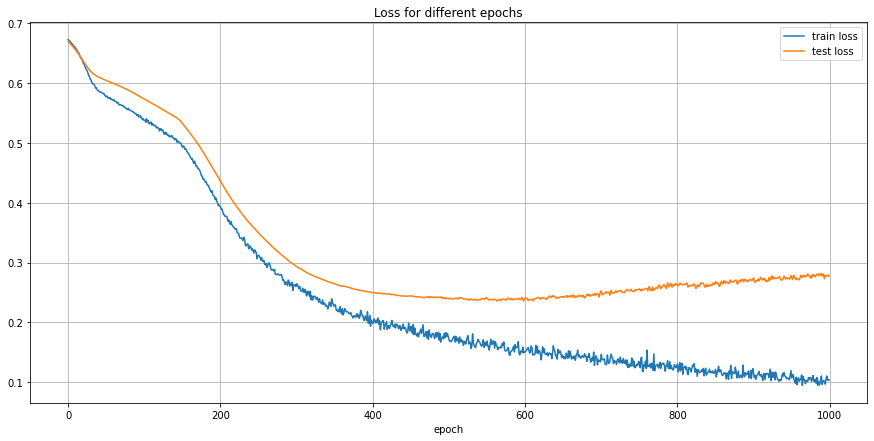

In [ ]:
plt.figure(figsize=(15, 7))
plt.grid()
plt.plot(range(clf.n_epochs), clf.train_loss, label='train loss')
plt.plot(range(clf.n_epochs), clf.val_loss, label='test loss')
plt.legend()
plt.title('Loss for different epochs')
plt.xlabel('epoch')

In [ ]:
clf.best_val_results

{'f1': 0.8928498118371535,
 'precision': 0.8939942907334212,
 'recall': 0.8917362589378309}

# Testing the model for different day_step

In [ ]:
best_results = []

args = {'num_features': len(features), 'num_filters': 8, 'batch_size': 128, 
        'epochs': 1000,
        'validate': True,
        "save_best_dev": False,
        "use_cuda": True,
        "print_every_step": 100,
        "eval_metrics": 'f1', 
        'drop': 0.13,
        'seq_len': 100, 
        'print_every_epoch': False}

In [ ]:
from tqdm import tqdm 

for day_step in tqdm(range(1, 50, 5)):
  data = pd.read_csv('Processed_NYSE.csv', date_parser= lambda x: pd.to_datetime(x, format='%Y-%m-%d'), parse_dates=['Date'])
  X, y = preprocess(data, day_step)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
  args['data_train'] =  (X_train, y_train)
  
  args['data_val'] = (X_test, y_test)
  clf = CNNStock(**args)
  clf.train()
  best_results.append(clf.best_val_results['f1'])


  0%|          | 0/10 [00:00<?, ?it/s]

Start training



 10%|█         | 1/10 [03:31<31:45, 211.75s/it]

Start training



 20%|██        | 2/10 [07:02<28:10, 211.37s/it]

Start training



 30%|███       | 3/10 [10:32<24:36, 210.96s/it]

Start training



 40%|████      | 4/10 [14:01<21:03, 210.53s/it]

Start training



 50%|█████     | 5/10 [17:31<17:30, 210.14s/it]

Start training



 60%|██████    | 6/10 [20:59<13:58, 209.54s/it]

Start training



 70%|███████   | 7/10 [24:28<10:28, 209.36s/it]

Start training



 80%|████████  | 8/10 [27:55<06:57, 208.90s/it]

Start training



 90%|█████████ | 9/10 [31:26<03:29, 209.34s/it]

Start training



100%|██████████| 10/10 [34:55<00:00, 209.55s/it]


In [ ]:
best_results

[0.4997972242249459,
 0.6582789686237962,
 0.697962648556876,
 0.7303762819029995,
 0.747386012393333,
 0.8223367205763084,
 0.7995210400273691,
 0.7918817321730334,
 0.8490820398516741,
 0.8928498118371535]

Text(0.5, 0, 'day_step')

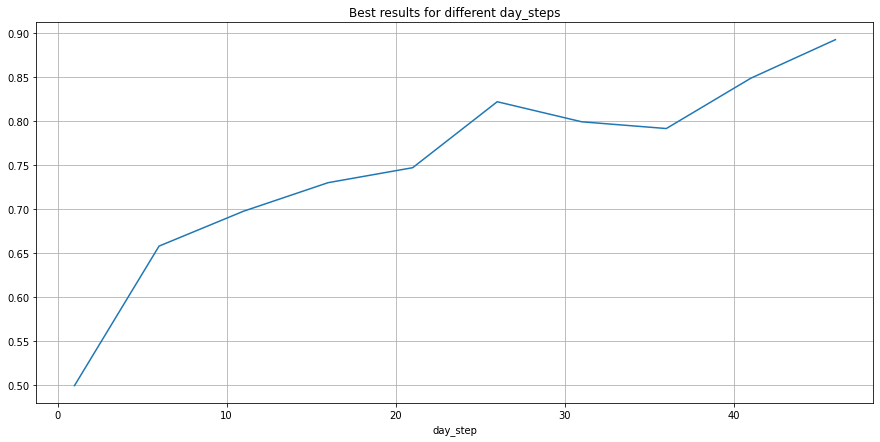

In [ ]:
plt.figure(figsize=(15, 7))
plt.grid()
plt.plot(range(1, 50, 5), best_results)
plt.title('Best results for different day_steps')
plt.xlabel('day_step')

# Time series prediction

In [ ]:
from torch.nn import Linear, ReLU, Conv2d, MaxPool2d, Dropout

class CNNStockNetwork(nn.Module):

    def __init__(self, num_features, num_filters, drop, **kwargs):
        super(CNNStockNetwork, self).__init__()

        self.conv1 = Conv2d(1, num_filters, kernel_size=(1, num_features))
        self.relu1 = ReLU()
        self.conv2 = Conv2d(num_filters, num_filters, kernel_size=(3, 1))
        self.relu2 = ReLU()
        self.pool1 = MaxPool2d(kernel_size=(2, 1))
        self.conv3 = Conv2d(num_filters, num_filters, kernel_size=(3, 1))
        self.relu3 = ReLU()
        self.pool2 = MaxPool2d(kernel_size=(2, 1))
        self.drop1 = Dropout(drop)
        self.fc1 = Linear(104, 1)
        self.loss = torch.nn.MSELoss()
 
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.pool1(x)
        x = self.relu3(self.conv3(x))
        x = self.pool2(x)
        x = self.drop1(x.view(x.shape[0], -1))
        x = self.fc1(x).squeeze(-1)
        return x

class CNNStock:         

    def __init__(self, **kwargs):

        default_kwargs = {
            'epochs': 7,
            'batch_size': 128,
            'validate': True,
            "save_best_dev": False,
            "use_cuda": True,
            "print_every_step": 1000,
            "eval_metrics": 'f1',
            'seq_len': 60
        }

        default_kwargs.update(kwargs)
        self.kwargs = default_kwargs

        self.network = CNNStockNetwork(**kwargs)

        self.n_epochs = kwargs["epochs"]
        self.batch_size = kwargs["batch_size"]
        self.use_cuda = kwargs["use_cuda"]
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1e-4)
        self.print_every_step = kwargs["print_every_step"]
        self.print_every_epoch = kwargs["print_every_epoch"]

        self.validate = kwargs["validate"]
        self.save_best_dev = kwargs["save_best_dev"]

        self.val_data = kwargs['data_val']
        self.train_data = kwargs['data_train']
        self.seq_len = kwargs['seq_len']

        self.device = 'cpu'
        if torch.cuda.is_available() and self.use_cuda:
            self.device = 'cuda:0'
        self.train_loss = []
        self.val_loss = []

    def window_data(self, data, target, seq_len=60):
        windowed_data = []
        windowed_target = []
        for index in range(data.shape[0] - seq_len + 1):
            windowed_data.append(data[index:index + seq_len])
            windowed_target.append(target[index])
        return np.array(windowed_data), np.array(windowed_target)

    def get_batches(self, data, target, batch_size, seq_len=60):
      windowed_data, windowed_target = self.window_data(data, target, seq_len=60)
      for i in range(0, len(windowed_data), batch_size):
        yield torch.from_numpy(windowed_data[i:i+batch_size]).unsqueeze(1).float(), torch.from_numpy(windowed_target[i:i+batch_size]).float()

    def train(self):
        # transfer model to gpu if available
        self.network = self.network.to(self.device)

        start = time.time()
        for epoch in range(1, self.n_epochs + 1):
            # turn on network training mode
            self.network.train()

            # forward and backward pass
            step = 0
            step_loss = 0
            for x, y in self.get_batches(*self.train_data, batch_size=self.batch_size, seq_len=self.seq_len):
                self.optimizer.zero_grad()
                logits = self.network(x)
                loss = self.network.loss(logits, y)
                step_loss += loss.item()
                loss.backward()
                self.optimizer.step()

                step += 1

            self.train_loss.append(step_loss / step)
            # validation
            if self.validate:
                if self.val_data is None:
                    raise RuntimeError(
                        "self.validate is True in trainer, "
                        "but dev_data is None."
                        " Please provide the validation data.")
                self.test(self.val_data)
        
    def test(self, dev_data, add_to_val_loss=True, threshold=0.5):
        # transfer model to gpu if available
        network = self.network.to(self.device)

        # turn on the testing mode; clean up the history
        network.eval()

        output_list = []
        truth_list = []
        output_toeval = []

        # predict
        step_loss = 0
        step = 0
        for x, y in self.get_batches(*dev_data, batch_size=self.batch_size, seq_len=self.seq_len):
            with torch.no_grad():
                logit = network(x)
                step_loss += network.loss(logit, y).item()
            output_toeval.append(logit.long().cpu().numpy())
            truth_list.append(y)
            step += 1
        
        # evaluate
        if add_to_val_loss:
          self.val_loss.append(step_loss / step)
    
    def predict(self, X):
        # transfer model to gpu if available
        network = self.network.to(self.device)

        # turn on the testing mode; clean up the history
        network.eval()
        output_toeval = []

        # predict
        for x, _ in self.get_batches(X, X, batch_size=self.batch_size, seq_len=self.seq_len):
            with torch.no_grad():
                logit = network(x)
            output_toeval.append(logit.long().cpu().numpy())
        return np.concatenate(output_toeval, axis=0)

In [ ]:
def preprocess(data, day_step=1):
  del data['Name']
  data = data.fillna(0)
  beg = data['Date'][0]
  data['Date'] = data['Date'].apply(lambda x: (x - beg).total_seconds())
  target = (data['Close'][day_step:]).to_numpy()
  
  data = data[:-day_step]
  scaler = StandardScaler()
  for feature in features:
    data[feature] = scaler.fit_transform(data[feature].to_numpy().reshape(-1, 1))
  X = data[features].to_numpy()
  return X, target

In [ ]:
data = pd.read_csv('Processed_NYSE.csv', date_parser= lambda x: pd.to_datetime(x, format='%Y-%m-%d'), parse_dates=['Date'])
X, y = preprocess(data, 50)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

In [ ]:
args = {'num_features': len(features), 'num_filters': 8, 'batch_size': 128, 
        'data_train': (X_train, y_train), 'data_val': (X_test, y_test),  'epochs': 1000,
        'validate': True,
        "save_best_dev": False,
        "use_cuda": True,
        "print_every_step": 100,
        'drop': 0.13,
        'seq_len': 60, 
        'print_every_epoch': True}

In [ ]:
regr = CNNStock(**args)

In [ ]:
regr.train()

Text(0.5, 0, 'epoch')

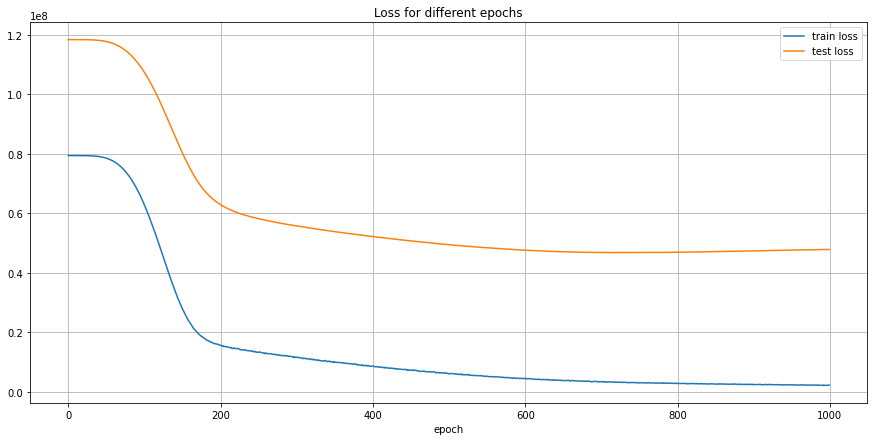

In [ ]:
plt.figure(figsize=(15, 7))
plt.grid()
plt.plot(range(regr.n_epochs), regr.train_loss, label='train loss')
plt.plot(range(regr.n_epochs), regr.val_loss, label='test loss')
plt.legend()
plt.title('Loss for different epochs')
plt.xlabel('epoch')

Text(0.5, 0, 'date a.u.')

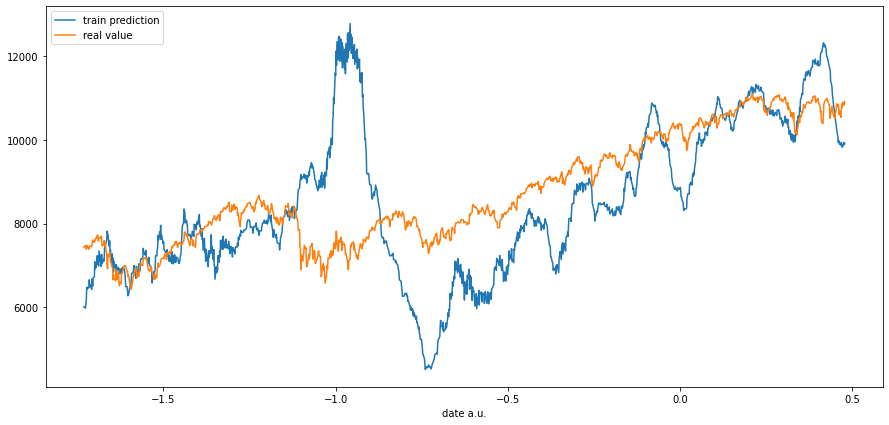

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(X_train[:-59, 0], regr.predict(X_train), label='train prediction')
plt.plot(X_train[:-59, 0], y_train[:-59], label='real value')
plt.legend()
plt.xlabel('date a.u.')

Text(0.5, 0, 'date a.u.')

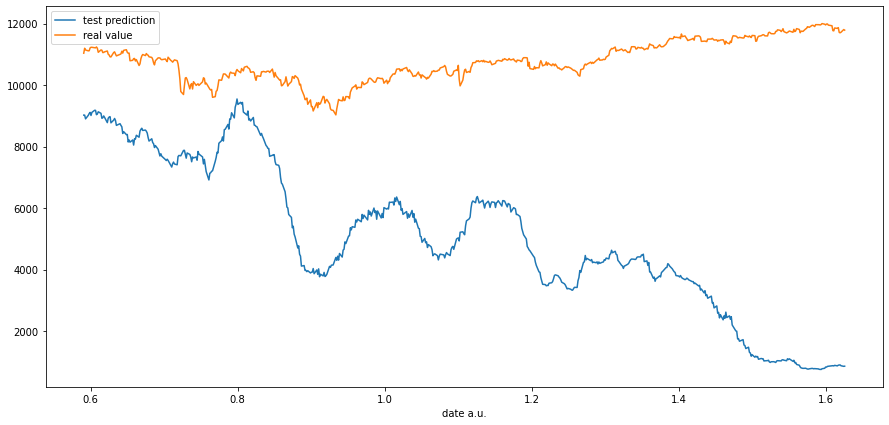

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(X_test[:-59, 0], regr.predict(X_test), label='test prediction')
plt.plot(X_test[:-59, 0], y_test[:-59], label='real value')
plt.legend()
plt.xlabel('date a.u.')